In [2]:
import json
from transformers import AdamW, get_linear_schedule_with_warmup
import warnings
warnings.filterwarnings("ignore")

from model import *
from dataloader import *
from train import *
from modelling import *

In [3]:
#Check GPU
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
n_gpu = torch.cuda.device_count()
print(device)

MAX_LEN = 256
BS = 32
DROPOUT_OUT = 0.3
tag_values = ['PAD', 'ADDRESS','SKILL','EMAIL','PERSON','PHONENUMBER','MISCELLANEOUS','QUANTITY','PERSONTYPE',
              'ORGANIZATION','PRODUCT','IP','LOCATION','O','DATETIME','EVENT', 'URL']
num_labels = len(tag_values)


linear_dropout = 0.3
bert_att_dropout = 0.15
bert_hidd_dropout = 0.2

bert_lr = 1e-5
bert_weight_decay = 1e-5
softmax_lr = 5e-4
softmax_weight_decay = 1e-3

cpu


In [4]:
dir_train = 'dataset/train_update_10t01.pkl'
dir_dev = 'dataset/dev_update_10t01.pkl'
dir_test = 'dataset/test_update_10t01.pkl'
dir_demo = 'dataset/demo.pkl'

with open('path.json', 'r', encoding= 'utf-8') as f:
        dict_path = json.load(f)

In [5]:
ner = NER(dict_path = dict_path, tag_values=tag_values, dropout = DROPOUT_OUT, max_len = MAX_LEN, device = device)

Some weights of XLMRobertaModel were not initialized from the model checkpoint at pretrain/xlmr_Model and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
#TRAIN = BertDataLoader(dir_train, ner.tokenizer, tag_values, maxlen = MAX_LEN, batch_size=BS,  device=device, is_train = False)
DEV = BertDataLoader(dir_dev, ner.tokenizer, tag_values=tag_values, max_len=MAX_LEN, batch_size=BS, device=device, is_train = False)
#TEST = BertDataLoader(dir_test, ner.tokenizer, tag_values, maxlen = MAX_LEN, batch_size=BS,  device=device, is_train = False)
DEMO = BertDataLoader(dir_demo, ner.tokenizer, tag_values=tag_values, max_len=MAX_LEN, batch_size=BS, device=device, is_train = False)

In [7]:
#train_loader, train_labels = TRAIN.create_dataloader()
dev_loader, dev_labels = DEV.create_dataloader()
#test_loader, test_labels = TEST.create_dataloader()
demo_loader, demo_labels = DEMO.create_dataloader()

In [8]:
cnt = -1
num_layer = 197
FINETUNING = True
if FINETUNING:
    param_optimizer1 = list(ner.model.named_parameters())[:num_layer]
    param_optimizer2 = list(ner.model.named_parameters())[num_layer:]
    no_decay = ['bias', 'LayerNorm.weight'] #['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer1 if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': bert_weight_decay},
        {'params': [p for n, p in param_optimizer1 if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0},
        
        {'params': [p for n, p in param_optimizer2 if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': softmax_weight_decay,
         'lr': softmax_lr},
        {'params': [p for n, p in param_optimizer2 if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0,
         'lr':softmax_lr},
    ]
optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=bert_lr)

In [ ]:
#PATH = 'weight/xlmr_span2_pool_nocat.pt'
PATH = 'weight/weight.pt'
epochs = 2
patience = 10
max_grad_norm = 1.0
total_steps = len(demo_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=int(total_steps/10), num_training_steps=total_steps)
model, history = train_model(model=ner.model, train_loader=demo_loader, dev_loader=demo_loader, 
                            scheduler=scheduler, optimizer=optimizer, tokenizer=ner.tokenizer, 
                            tag_values=tag_values, device=device,epochs=epochs, patience=patience, 
                            max_grad_norm=max_grad_norm, PATH=PATH, strict=0)

In [9]:
ner.model = load_model(ner.model, 'weight/xlmr_span2_pool_nocat.pt', device)

In [11]:
sentence = "Tôi là sinh viên Tân."
result = ner.predict(sentence)
utils.visualize_spacy(result)

IndexError: list index out of range

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [25]:
tag_values = ['PER', 'LOC', 'ORG', 'EVENT', 'PERTYPE', 'PRO', 'SKILL',
'ADD', 'PHONE', 'EMAIL', 'URL', 'IP', 'DATETIME', 'QUAN', 'MISC']
train_ori = np.array([7896, 9579, 6671, 1275, 2633, 2020, 35, 54, 144, 40, 165, 58, 3807, 6981, 465])
dev_ori = np.array([1500, 1790, 1190, 116, 327, 299, 0, 2, 8, 0, 14, 0, 537, 1120, 83])
test_ori = np.array([3517, 1829, 2391, 160, 1318, 1263, 0, 2, 3, 1, 33, 0, 1677, 2570, 89])
 
train_new = np.array([9094, 10576, 8642, 1858, 3955, 3032, 119, 385, 190, 49, 203, 60, 5246, 10442, 1002])
dev_new = np.array([1943, 1302, 1598, 211, 695, 635, 43, 29, 9, 7, 17, 10, 1007, 1904, 159])
test_new = np.array([3248, 2397, 2696, 367, 1063, 1180, 51, 40, 24, 13, 43, 23, 1854, 3307, 310])


In [67]:
aa = np.sum([train_ori, dev_ori, test_ori], axis=0)
bb = np.sum([train_new, dev_new, test_new], axis=0)
cc = bb - aa
dd = np.round(cc / aa, 2)
ee = np.round(aa / aa, 2)
print(aa)
print(bb)
print(cc)
print(dd)
print(ee)

[12913 13198 10252  1551  4278  3582    35    58   155    41   212    58
  6021 10671   637]
[14285 14275 12936  2436  5713  4847   213   454   223    69   263    93
  8107 15653  1471]
[1372 1077 2684  885 1435 1265  178  396   68   28   51   35 2086 4982
  834]
[0.11 0.08 0.26 0.57 0.34 0.35 5.09 6.83 0.44 0.68 0.24 0.6  0.35 0.47
 1.31]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


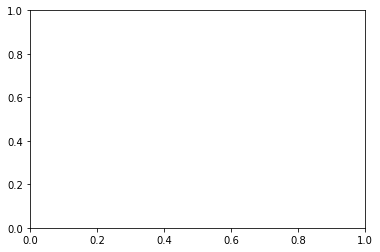

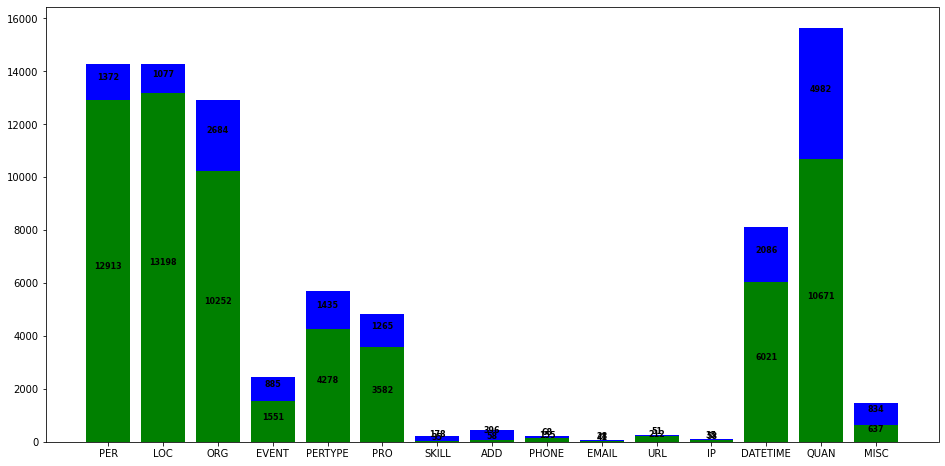

In [57]:
import numpy as np
import matplotlib.pyplot as plt

A = aa
B = cc

fig = plt.figure(facecolor="white")
ax = fig.add_subplot(1, 1, 1)
bar_width = 0.5
bar_l = np.arange(1, 17)
tick_pos = [i + (bar_width / 2) for i in bar_l]

# ax1 = ax.bar(bar_l, A, width=bar_width, label="A", color="green")
# ax2 = ax.bar(bar_l, B, bottom=A, width=bar_width, label="B", color="blue")
plt.figure(figsize=(16,8))
ax1 = plt.bar(tag_values, aa, align='center', color='green')
ax2 = plt.bar(tag_values, cc, align='center', bottom=aa, color='blue')

for r1, r2 in zip(ax1, ax2):
    h1 = r1.get_height()
    h2 = r2.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1, ha="center", va="bottom", color="black", fontsize=8, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2, ha="center", va="bottom", color="black", fontsize=8, fontweight="bold")

plt.show()

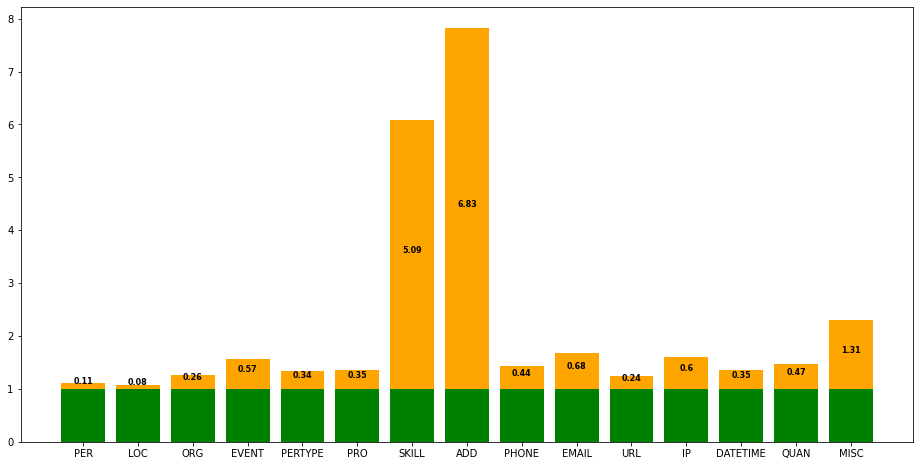

In [95]:
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha ='center', va='top')
plt.figure(figsize=(16,8))
ax1 = plt.bar(tag_values, ee, align='center', color='green')
#addlabels(tag_values, dd)
ax2 = plt.bar(tag_values, dd, align='center', bottom=ee, color='orange')

#plt.bar_label(ax2.containers[0])
# function to add value labels
# function to add value labels
for r1, r2 in zip(ax1, ax2):
    h1 = r1.get_height()
    h2 = r2.get_height()
    #plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%a" % h1, ha="center", va="bottom", color="black", fontsize=8, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., np.round(h2, 2), ha="center", va="bottom", color="black", fontsize=8, fontweight="bold")

plt.show()